# The Metropolitan Museum of Art: Open Access CSV

### Kate Stadelman
### Tools One Final Project, Winter 2022

<center><img src="images/met_art.png" alt="Art at The Met" style="width: 1000px;"/><center>

In [1]:
from ast import Assert
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import requests
import seaborn as sns
import scipy.stats as ss
import shap
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import RobustScaler

%matplotlib inline

## Dataset & Motivation

The Metropolitan Museum of Art ("The Met") launched its <a href="https://www.metmuseum.org/about-the-met/policies-and-documents/open-access">Open Access Initiative</a> in February of 2017, releasing information on more than 470,000 artworks in its Collection for unrestricted commercial and noncommercial use. Per The Met's website: "The Open Access initiative represents an incredible body of ongoing work by curators, conservators, photographers, librarians, cataloguers, interns, and technologists over the past 151 years of the institution's history - new images and data are added each year. It is also an important statement about The Met's commitment to increasing access to the collection in a digital age. In the last four years, Open Access images and data have been viewed over 1.2 billion times and downloaded over 7 million times." 

This research project utilizes <a href="https://github.com/metmuseum/openaccess">The Met Open Access CSV</a>, which contains 52 manually cataloged attributes describing the artwork itself, artists, cultures, geographies, classifications, department, and gallery numbers. Additionally, the data file notes the year The Met took ownership of the artwork (Accession Year), as well as indicates if the artwork is a highlight piece, part of the <a href="https://www.metmuseum.org/toah/">Heilbrunn Timeline of Art History</a>, or in the public domain.

### The Met Open Access CSV Data Elements
* Object Number
* Is Highlight
* Is Timeline Work
* Is Public Domain
* Object ID
* Gallery Number
* Department
* Accession Year
* Object Name
* Title
* Culture
* Period
* Dynasty
* Reign
* Portfolio
* Constituent ID
* Artist Role
* Artist Prefix
* Artist Display Name
* Artist Display Bio
* Artist Suffix
* Artist Alpha Sort
* Artist Nationality
* Artist Begin Date
* Artist End Date
* Artist Gender
* Artist ULAN URL
* Artist Wikidata URL
* Object Date
* Object Begin Date
* Object End Date
* Medium
* Dimensions
* Credit Line
* Geography Type
* City
* State
* County
* Country
* Region
* Subregion
* Locale
* Locus
* Excavation
* River
* Classification
* Rights and Reproduction
* Link Resource
* Object Wikidata URL
* Metadata Date
* Repository
* Tags
* Tags AAT URL
* Tags Wikidata URL



### Fetching & Loading The Met Open Access CSV

<a href="https://github.com/metmuseum/openaccess">The Met Open Access CSV</a> is available via GitHub. Because the dataset is consistently being manually updated, we enforce a specific commit to ensure our code works appropriately. We begin by downloading the dataset and its companion readme and license information and then load the data into a dataframe.

In [3]:
# enforce a specific commit (cc6310135aeafd01fb03588929fb9d00c5cbc606) from Jan 17, 2022 because data is manually input with no tagged releases
sources = {
    'license': {
        'url': 'https://raw.githubusercontent.com/metmuseum/openaccess/cc6310135aeafd01fb03588929fb9d00c5cbc606/',
        'file': 'LICENSE'
    },
    'readme': { 
        'url': 'https://raw.githubusercontent.com/metmuseum/openaccess/cc6310135aeafd01fb03588929fb9d00c5cbc606/', 
        'file': 'README.md' 
    }, 
    'data': { 
        'url': 'https://media.githubusercontent.com/media/metmuseum/openaccess/cc6310135aeafd01fb03588929fb9d00c5cbc606/', 
        'file': 'MetObjects.csv',
        'checksum': '68d26f76485ccd066d45b6044d0954f1508e431a21c4ef7133f45c46931d4773' 
    }
}

In [4]:
# define path for saving off data and make a data directory if needed
data_path = os.path.join(os.getcwd(), 'data', '')
if not os.path.exists(data_path):
    os.mkdir(data_path)

In [ ]:
def get_data(source, outpath):
    # get data and output to file
    try:
        r = requests.get(source['url'] + source['file'])
        r.raise_for_status()
        r.encoding = 'UTF-8'
        with open(outpath + source['file'], 'w') as f:
            f.write(r.text)
    except requests.exceptions.RequestException as e:
        print('Requests Error:', e)

    # validate data file
    if 'checksum' in source:
        try:
            with open(outpath + source['file'],"rb") as f:
                bytes = f.read()                                        # read entire file in as bytes
                readable_hash = hashlib.sha256(bytes).hexdigest()
            assert source['checksum'] == readable_hash                  # compare SHA256 hash
        except AssertionError:
            print('SHA256 Error:', source['checksum'], readable_hash)  

# download data
for source in sources:
    get_data(source=sources[source], outpath=data_path)

In [5]:
# load data to dataframe
df = pd.read_csv(data_path + sources['data']['file'], sep=',', index_col=4, low_memory=False)

In [6]:
# display data sample
df.sample(5)

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,...,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
Object ID,,,,,,,,,,,,,,,,,,,,,
226654,41.141.8,False,False,False,NaN,European Sculpture and Decorative Arts,1941,Handkerchief,Handkerchief,French,...,NaN,Textiles-Embroidered,NaN,http://www.metmuseum.org/art/collection/search...,NaN,NaN,"Metropolitan Museum of Art, New York, NY",Butterflies,http://vocab.getty.edu/page/aat/300417320,https://www.wikidata.org/wiki/Q11946202
833991,58.638.209,False,False,False,NaN,Drawings and Prints,1958,"Drawings, Ornament & Architecture",Carriage drawing No 6180,NaN,...,NaN,Drawings|Ornament & Architecture,NaN,http://www.metmuseum.org/art/collection/search...,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
489634,67.187.68,False,True,False,NaN,European Paintings,1967,Painting,Comical Repast (Banquet of the Starved),NaN,...,NaN,Paintings,NaN,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19912350,NaN,"Metropolitan Museum of Art, New York, NY",Food|Skeletons|Men|Women|Dining|Banquets,http://vocab.getty.edu/page/aat/300254496|http...,https://www.wikidata.org/wiki/Q2095|https://ww...
286871,2006.226,False,False,False,NaN,Photographs,2006,Photograph,San Casciano,NaN,...,NaN,Photographs,George Tatge / Fratelli Alinari,http://www.metmuseum.org/art/collection/search...,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
254779,53.11.6,True,True,True,151,Greek and Roman Art,1953,Stirrup jar with octopus,Terracotta stirrup jar with octopus,"Helladic, Mycenaean",...,NaN,Vases,NaN,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q29383912,NaN,"Metropolitan Museum of Art, New York, NY",Fish|Octopus,http://vocab.getty.edu/page/aat/300266085|http...,https://www.wikidata.org/wiki/Q152|https://www...


## Research Questions

The primary research question of our project is: <i>Can we determine artwork features that make it likely to be a highlight piece?</i>

This main topic leads to several secondary questions:
* Which attributes represent the artwork's artist, time, geography, and medium? How can we turn these into meaningful features?
* Of all available attributes, which are the cleanest and most reliable?
* Artworks are unlikely to become highlight pieces if they are not displayed. Is there an attribute that can be used to determine if an artwork is displayed?
* Are there any outlier collections that should be analyzed separately?

We begin by answering our secondary research questions using all of the dataset's observations and attributes. The output of this preliminary analysis is a final dataset that is then used for data mining. Using Random Forest and other visualizations, we attempt to determine which features of this final dataset make it likely that an artwork is a highlight piece.

## Literature Review

There is not much publically available in terms of published works on The Met Open Access CSV. We did find an article, <a href="https://medium.com/towards-data-science/metropolitan-museum-of-art-data-analysis-and-visualization-7d1d023c68fe">The Metropolitan Museum of Art Data Analysis and Visualization</a>, that performs exploratory data analysis on our dataset. Below we included two visualizations similar to what is covered in the article, displaying the top artists and cultures found at The Met. While these visualizations are interesting, they do not fully account for gaps in the data. For example, in our research, we show that culture is populated for only roughly 40% of artworks. Our research is novel in that it fully analyzes data gaps and outliers, as well as extracts features from attributes with many distinct values. Moreover, we employ advanced techniques, such as one-hot encoding, and data mine with Random Forest.


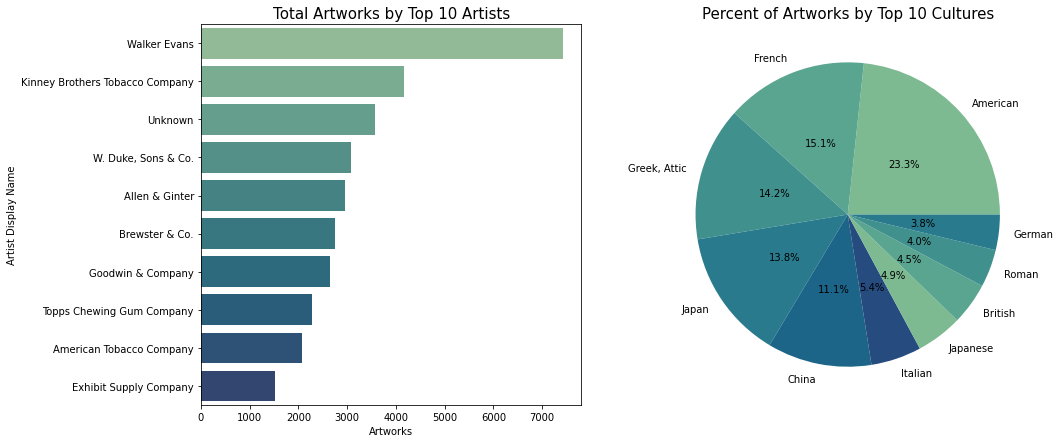

In [20]:
# top artists and cultures
top_artists = df[['Artist Display Name', 'Object Number']].groupby('Artist Display Name')['Object Number'].count()
top_artists = top_artists.rename_axis('Artist Display Name').reset_index()
top_artists = top_artists.rename(columns={'Object Number':'Artworks'})
top_artists = top_artists.sort_values(by='Artworks', ascending=False).head(10)
top_cultures = df[['Culture', 'Object Number']].groupby('Culture')['Object Number'].count()
top_cultures = top_cultures.rename_axis('Culture').reset_index()
top_cultures = top_cultures.rename(columns={'Object Number':'Artworks'})
top_cultures = top_cultures.sort_values(by='Artworks', ascending=False).head(10)

fig, axes = plt.subplots(1,2,figsize=(15,7))
fig.set_facecolor('white')
sns.set_palette('mako')
sns.barplot(x='Artworks', y='Artist Display Name', data=top_artists, ax=axes[0], palette=sns.color_palette('crest',10))
axes[0].set_title('Total Artworks by Top 10 Artists', fontsize=15)
data = top_cultures['Artworks']
labels = top_cultures['Culture']
colors = sns.color_palette('crest')[0:10]
axes[1] = plt.pie(x=data, labels=labels, colors=colors, autopct='%.1f%%', pctdistance=0.5)
plt.title('Percent of Artworks by Top 10 Cultures', fontsize=15)
plt.show()


## Data Cleaning & Feature Extraction

We start our data preparation process with a visualization of the percentage of NaNs alongside the number of unique values for each attribute.

In [22]:
nans_df = pd.DataFrame(df.isna().mean().mul(100).round(), columns=['Percent NaN'])
nans_df['Unique Values'] = df.nunique()
nans_df = nans_df.rename_axis('Attribute').reset_index()
nans_df.sort_values(by=['Percent NaN'], inplace=True)

# removing columns that we would not consider using as features
nans_df = nans_df[(nans_df['Attribute']!='Object Number') & (nans_df['Attribute']!='Link Resource')
                  & (nans_df['Attribute']!='Title') & (nans_df['Attribute']!='Dimensions')]

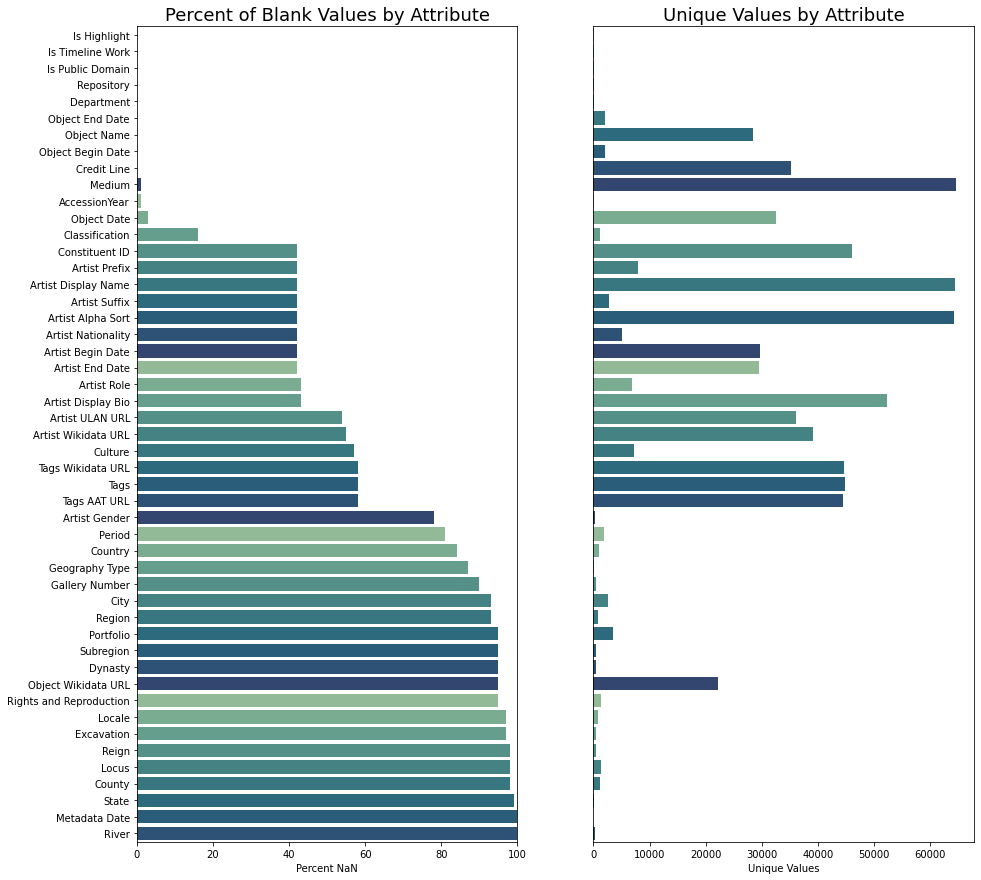

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15,15))
sns.barplot(x='Percent NaN', y='Attribute', data=nans_df, ax=axes[0], palette=sns.color_palette('crest',10))
axes[0].set_xlim(0,100)
axes[0].set_title('Percent of NaNs by Attribute', fontsize=18)
axes[0].set(ylabel=None)
sns.barplot(x='Unique Values', y='Attribute', data=nans_df, ax=axes[1], palette=sns.color_palette('crest',10))
axes[1].set_title('Unique Values by Attribute', fontsize=18)
axes[1].set(ylabel=None)
axes[1].set_yticks([])
plt.show()

In [76]:
# too many distinct artists to use as a categorical variable
print('Unique Artists:', df['Artist Display Name'].nunique())
print('Unique Artists with Highlight Works:', df['Artist Display Name'][df['Is Highlight'] == True].nunique())

# too many distinct credit lines to use as a categorical variable
print('\nUnique Credit Lines:', df['Credit Line'].nunique())
print('Unique Credit Lines with Highlight Works:', df['Credit Line'][df['Is Highlight'] == True].nunique())

# too many distinct mediums to use as a categorical variable
print('\nUnique Mediums:', df['Medium'].nunique())
print('Unique Mediums with Highlight Works:', df['Medium'][df['Is Highlight'] == True].nunique())

Unique Artists: 64330
Unique Artists with Highlight Works: 1328

Unique Credit Lines: 35247
Unique Credit Lines with Highlight Works: 1421

Unique Mediums: 64564
Unique Mediums with Highlight Works: 1245


From the above visualization and specific unique value counts, we make two concerning observations about The Met data:

* Over half of the attributes are blank more than 50% of the time
* With a large number of unqiue values, attributes do not appear to be conformed in a meaningful way

### Clean(ish) Dataframe
We create a dataframe with known good attributes of Department, Is Highlight, and Is Timeline Work. Also, we find we can use whether Gallery Number is populated as a proxy for whether the artwork is displayed.

In [25]:
# begin our dataframe with 'best' data
met_df = df[['Department','Is Highlight','Is Timeline Work']].copy()                              # Department, Is Highlight, & Is Timeline Work look good

# use gallery number as a proxy for whether the artwork is displayed
met_df['Is Displayed'] = df['Gallery Number'].apply(lambda x: False if x == np.nan else True)     # consider art displayed if it has a gallery number

(477202, 4)


#### Accession Year
Next, we clean Accession Year, which is the year The Met became owner of the artwork. There is little quality control in this dataset, and we find that year is sometimes entered as a full date (YYYY-MM-DD). For these entries, we extract the year. Moreover, for rows where Accession Year is blank, we find that Credit Line often has an embedded year when The Met was gifted the artwork.

Credit Line Examples:
* Gift of Morrison and Fenella Heckscher, 2020
* Gift of Dr. Sidney A. Charlat, in memory of his sister, Bertie Grossman, 1982
* Gift of George C. Miles, 1962
* Gift of Harold G. Henderson, 1966

In [26]:
# accession year
met_df['Accession Year'] = df['AccessionYear'].apply(lambda x: str(x)[0:4] if isinstance(x, str) else x)      # accession year is sometimes YYYY-MM-DD
met_df['Credit Line'] = df['Credit Line']
met_df['Credit Line Year'] = met_df['Credit Line'].str.extract(r'(\d{4})', expand = True)                     # extract gifted year from credit line
met_df['Accession Year'].fillna(met_df['Credit Line Year'], inplace=True)
met_df.drop(columns=['Credit Line','Credit Line Year'], inplace=True)
met_df.dropna(inplace=True)                                                                                   # drop rows where we cannot populate a year
met_df['Accession Year'] = met_df['Accession Year'].astype(int)
print(met_df.shape)

(474280, 5)


#### Object Year

Object Date is quite a mess with a variety of formats. Instead, we will use Object Begin Date to approximate the year in which the artwork was made.

Object Date Examples:
* after 1566
* ca. 1735–36
* January 5, 1786
* 1760–1819

While Object Begin Date is consistently an integer, we find date entries of zero when the object's date is unknown. These entries are removed.

In [27]:
# after close review, object begin date more closely reflects object date, with a more consistent format
# entires are all integers, but we find entries of 0 for unknown object begin/end dates
df['Object Begin Date'] = df['Object Begin Date'].astype(int)
df['Object End Date'] = df['Object End Date'].astype(int)
met_df['Object Year'] = df['Object Begin Date']                       
met_df = met_df.loc[(df['Object Begin Date']!=0) & (df['Object End Date']!=0) & (df['Object Begin Date']<=df['Object End Date'])]      # remove unknowns   
met_df['Object Year'] = met_df['Object Year'].astype(int)
print(met_df.shape)

(472901, 6)


#### Classification

While not as exact as Object Name or Medium, Classification provides a useful understanding of the type of artwork and material. However, there are still too many unique values to be used as a categorical variable in our Random Forest data mining exercise. 

Classification Examples:

* Stone-Reliefs-Inscribed
* Armor Parts-Gauntlets
* Accessory-Neckwear-Womenswear
* Metalwork-Jewelry
* Membranophone-single-headed / biconical drum
* Collages-Drawings

Through analysis, we find there is a relatively small set of classification words that account for a large proprotion of classification entries. We simplify classifications using this reduced list.

In [28]:
# classifications
print('Percent of Blank Classifications:', round((df['Classification'].isnull().sum()/df.shape[0])*100,2))
print('Number of Unique Classifications:', df['Classification'].nunique())

met_df = met_df.loc[~df['Classification'].isna()]

Percent of Blank Classifications: 16.38
Number of Unique Classifications: 1205


In [29]:
# search for the following classification words in the detailed classification
classifications = [ 'Print', 'Textile', 'Photograph', 'Drawing', 'Vase', 'Book', 'Ceramic', 'Metal', 'Painting', 'Glass', 'Negative', 'Sculpture', 'Sword',
                   'Stone', 'Wood', 'Jewelry']
met_df['Classification'] = df['Classification'].apply(lambda x: [ i for i in classifications if i in str(x) ])
met_df['Classification'] = met_df['Classification'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

In [30]:
print('Percent of Non-Blank Classifications Belonging to Top', len(classifications), 'Classifications',
      round((met_df['Classification'].value_counts().sum()/met_df.shape[0])*100,2))

Percent of Non-Blank Classifications Belonging to Top 16 Classifications 87.38


We account for ~87% of populated classifications using only 16 words (in comparison to the 1,205 unique classification values)!

In [77]:
# drop all remaining NaNs and set types
met_df.dropna(inplace=True)
met_df['Department'] = met_df['Department'].astype('category')
met_df['Classification'] = met_df['Classification'].astype('category')
met_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345844 entries, 5209 to 857173
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Department        345844 non-null  category
 1   Is Highlight      345844 non-null  bool    
 2   Is Timeline Work  345844 non-null  bool    
 3   Is Displayed      345844 non-null  bool    
 4   Accession Year    345844 non-null  int64   
 5   Object Year       345844 non-null  int64   
 6   Classification    345844 non-null  category
dtypes: bool(3), category(2), int64(2)
memory usage: 9.6 MB


## Exploratory Data Analysis

After cleaning our dataset and extracting features, it is time to perform exploratory data analysis and handly any outliers.

In [32]:
met_df.sample(5)

,Department,Is Highlight,Is Timeline Work,Is Displayed,Accession Year,Object Year,Classification
Object ID,,,,,,,
395347,Drawings and Prints,False,False,True,1924,1805,Print
345246,Drawings and Prints,False,False,True,1960,1900,Book
700469,Drawings and Prints,False,False,True,1946,1910,Drawing
262274,Photographs,False,False,True,1978,1938,Photograph
348558,Drawings and Prints,False,False,True,1952,1743,Book


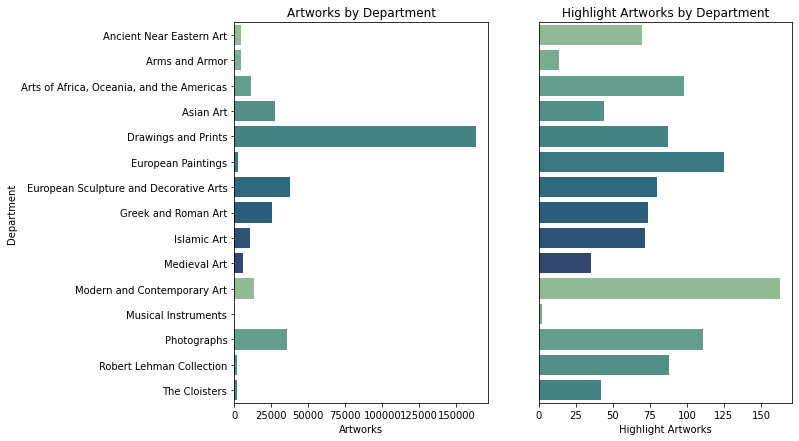

In [34]:
# artworks by department
fig, axes = plt.subplots(1, 2, figsize=(10,7))
sns.countplot(y='Department', data=met_df, ax=axes[0], palette=sns.color_palette('crest',10))
axes[0].set_title('Artworks by Department', fontsize=12)
axes[0].set(xlabel='Artworks')
sns.countplot(y='Department', data=met_df[met_df['Is Highlight']==True], ax=axes[1], palette=sns.color_palette('crest',10))
axes[1].set_title('Highlight Artworks by Department', fontsize=12)
axes[1].set(xlabel='Highlight Artworks')
axes[1].set(ylabel=None)
axes[1].set_yticks([])
plt.show()

Even though most artworks are in the Drawings & Paintings department, most highlighed pieces are in the Modern & Contemporary Art department. Interestingly, the distribution of highlighted works is relatively even across departments in comparison to the distribution of the full Collection.

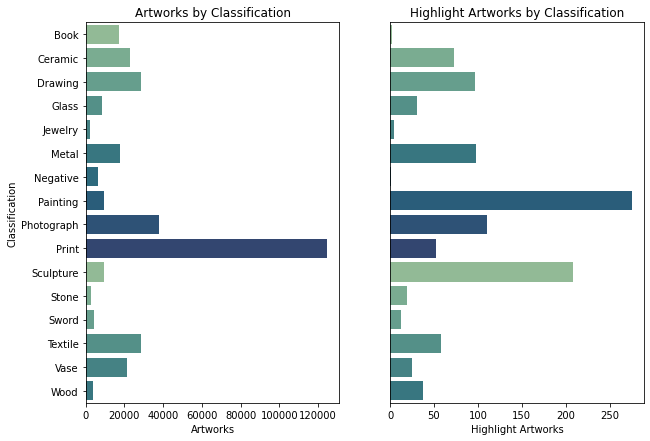

In [35]:
# artworks by classification
fig, axes = plt.subplots(1, 2, figsize=(10,7))
sns.countplot(y='Classification', data=met_df, ax=axes[0], palette=sns.color_palette('crest',10))
axes[0].set_title('Artworks by Classification', fontsize=12)
axes[0].set(xlabel='Artworks')
sns.countplot(y='Classification', data=met_df[met_df['Is Highlight']==True], ax=axes[1], palette=sns.color_palette('crest',10))
axes[1].set_title('Highlight Artworks by Classification', fontsize=12)
axes[1].set(xlabel='Highlight Artworks')
axes[1].set(ylabel=None)
axes[1].set_yticks([])
plt.show()

While the Collection contains far more prints than any other classification of artwork, highlighted pieces are more often paintings and sculptures.

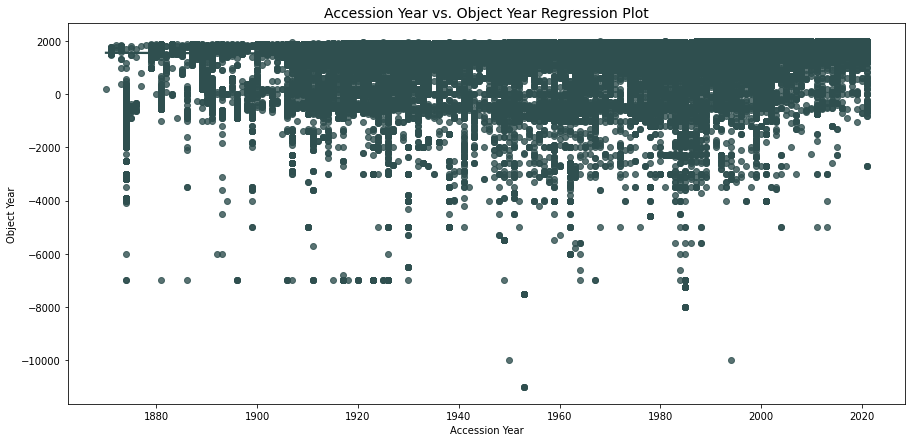

In [78]:
# regression plot between accession year and object year
fig = plt.figure(figsize=(15,7))
ax = sns.regplot(x='Accession Year', y='Object Year', data=met_df, color='darkslategrey')
ax.set_title('Accession Year vs. Object Year Regression Plot', fontsize=14)
ax.set_xlabel('Accession Year')
ax.set_ylabel('Object Year')
plt.show()

There does not appear to be a correlation between Accession Year and Object Year.

In [37]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [38]:
dpt_cl_cm = pd.crosstab(met_df['Department'], met_df['Classification'])
print('Cramér\'s V between Department & Classification:', cramers_v(dpt_cl_cm.values))

Cramér's V between Department & Classification: 0.5431585108922641


In [39]:
ht_cm = pd.crosstab(met_df['Is Highlight'], met_df['Is Timeline Work'])
print('Cramér\'s V between Highlight & Timeline Work:', cramers_v(ht_cm.values))

Cramér's V between Highlight & Timeline Work: 0.3118106577227118


In checking correlations between our categorical variables, there does not appear to be as strong correlation between Is Highlight and Is Timeline Work, but there does appear to be a slight correlation between department and classification, but nothing that would prevent us from using both in our Random Forest data mining exercise.

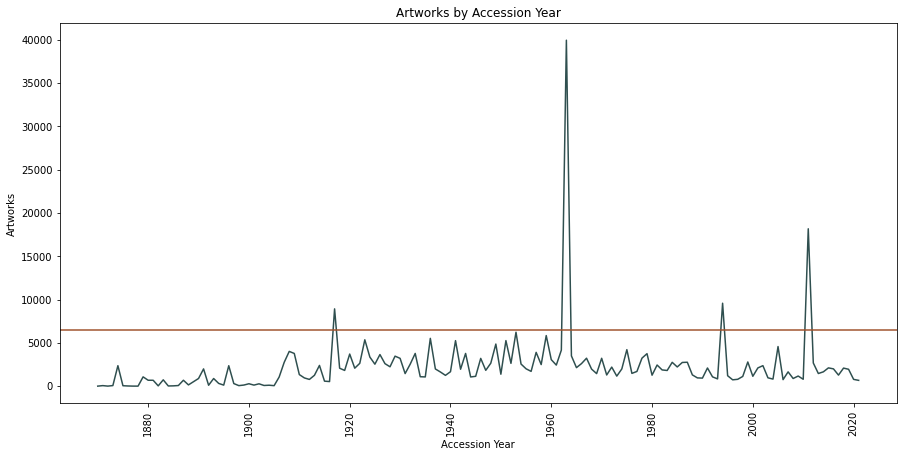

In [80]:
# artworks by accession year
acc_yr = met_df.groupby(['Accession Year'])['Department'].count()
acc_yr = acc_yr.rename_axis('Accession Year').reset_index()
acc_yr = acc_yr.rename(columns={'Department':'Count'})

fig = plt.figure(figsize=(15,7))
ax = sns.lineplot(x='Accession Year', y='Count', data=acc_yr, color='darkslategrey')
ax.set(title='Artworks by Accession Year', xlabel='Accession Year', ylabel='Artworks')
plt.xticks(rotation = 90)
plt.axhline(6500, color='sienna')
plt.show()

In [82]:
acc_yr.sort_values(by='Count', ascending=False).head(6)

,Accession Year,Count
93,1963,39953
141,2011,18173
124,1994,9576
47,1917,8925
83,1953,6228
89,1959,5839


For our final exploratory data analysis visualization, we look at the number of artworks by accession year. We find four years that have exceptionally high numbers. In the next section, we examine each of these to understand why so many more artworks were acquired than ususal and also determine if these collections are outliers that should be analyzed separately and removed from our model.

## Accession Year Outliers

Through our exploratory data analysis, we identified four years (1963, 2011, 1994, and 1917) with exceptionally high numbers of artwork acquisitions. Reviewing the associated Credit Lines for these years, we find that we have unintentionally discovered the four largest individual giftings to The Met throughout its history. In the following section, we review these special collections.


### The Jefferson R. Burdick Collection

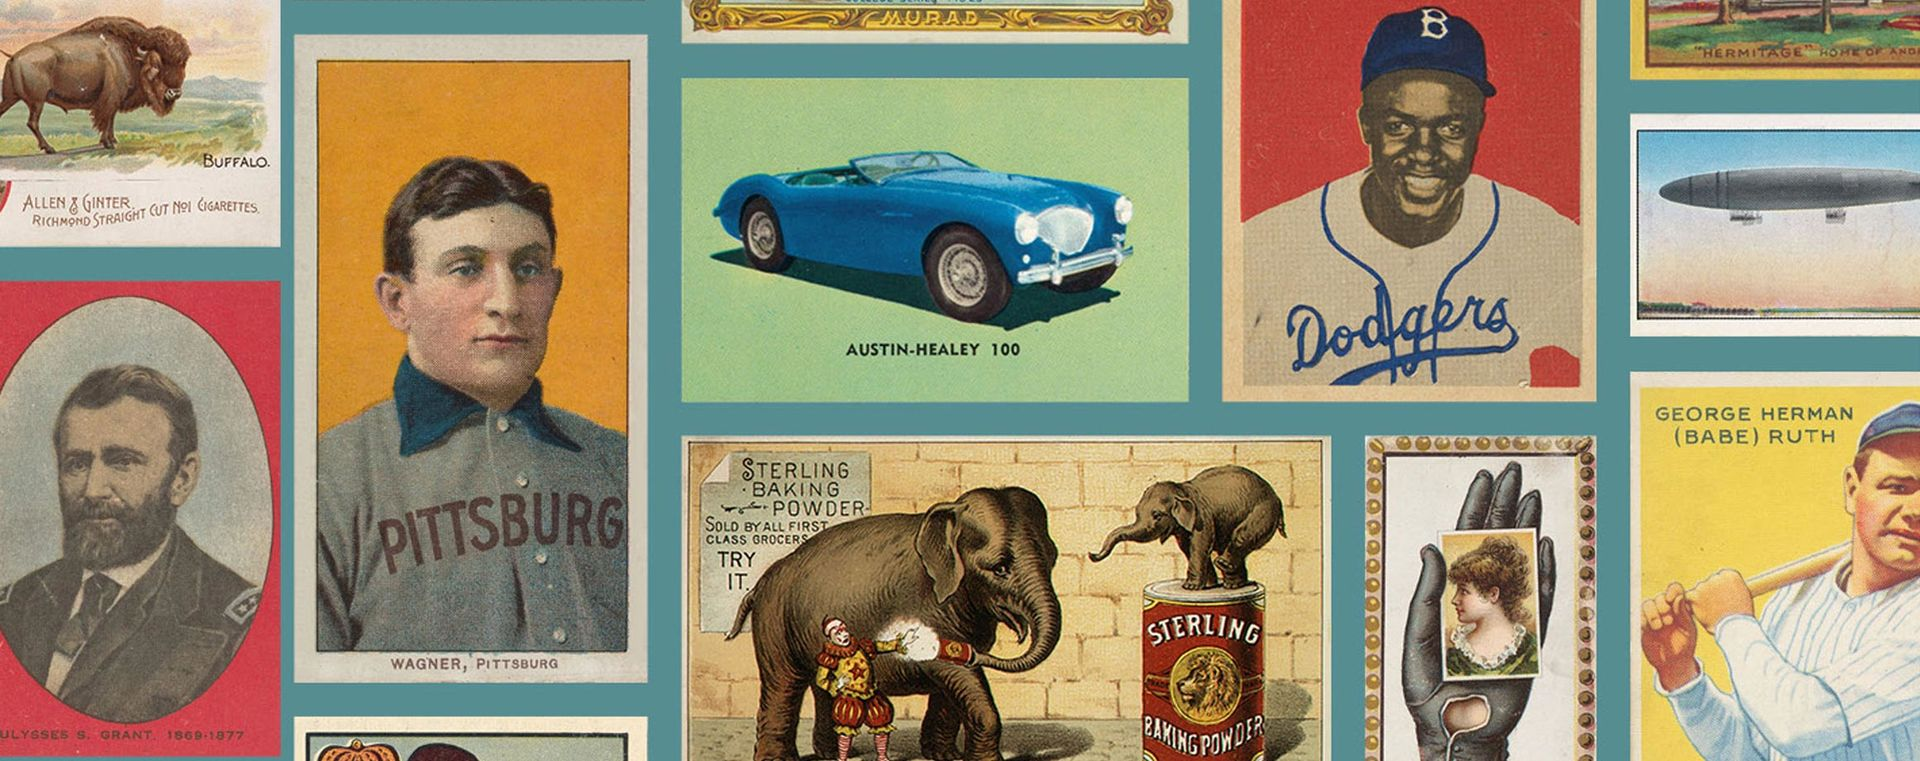

In 1947, after having reached an agreement with A. Hyatt Mayor, curator of prints and photographs, Syracuse electrician Jefferson R. Burdick (1900–1963) began to donate his entire collection of approximately 303,000 advertising inserts, postcards, and posters in large batches to The Metropolitan Museum of Art. The <a href="https://www.metmuseum.org/about-the-met/collection-areas/drawings-and-prints/burdick-collection">The Jeffersion R. Burdick Collection</a> constitutes a primary part of the Museum's collection of ephemera, and helps tell the history of popular printmaking in the United States.

Collected by Burdick from the age of ten, the cards date from the 1860s to 1963. Dissatisfied with the initial organization and storage system of the enormous gift, Mayor had Burdick install his little Art Nouveau oak desk from home in the only available corner of the department and compile the collection himself into albums. Burdick spent the next fifteen years in the Museum creating a structure for various types of contemporary advertising material. In organizing the albums Burdick adhered to a strict cataloguing system that he devised and published as the American Card Catalog (first edition 1939, with revised editions appearing through 1960). Burdick's method remains the standard system used by all collectors of early American printed ephemera.



In [42]:
# credit line
credit_line_1963 = df[df['AccessionYear']=='1963'].groupby('Credit Line')['Object Number'].count()
print(credit_line_1963.sort_values(ascending=False).head(1))

Credit Line
The Jefferson R. Burdick Collection, Gift of Jefferson R. Burdick    37118
Name: Object Number, dtype: int64


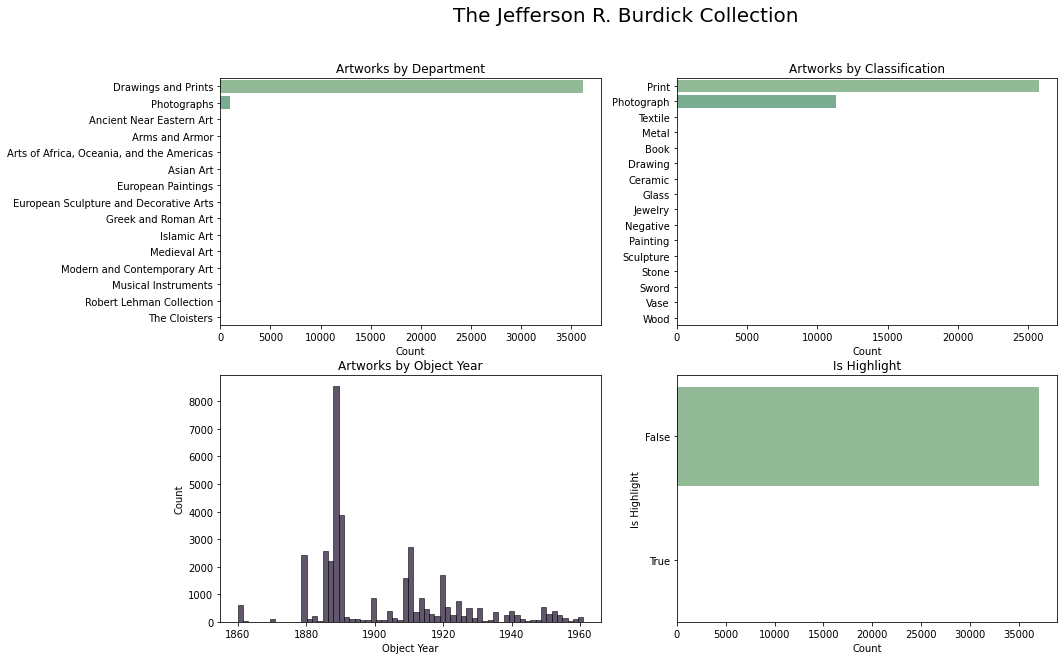

In [83]:
# burdick collection visualization
burdick = met_df.loc[(met_df['Accession Year']==1963) & (df['Credit Line']=='The Jefferson R. Burdick Collection, Gift of Jefferson R. Burdick')]

fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.countplot(y='Department', data=burdick, order=burdick['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=burdick, order=burdick['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=burdick, ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.countplot(y='Is Highlight', data=burdick, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Is Highlight', fontsize=12)
axes[1,1].set(xlabel='Count')
plt.suptitle('The Jefferson R. Burdick Collection', fontsize=20)
plt.show()

### The Dietrich von Bothmer Fragment Collection

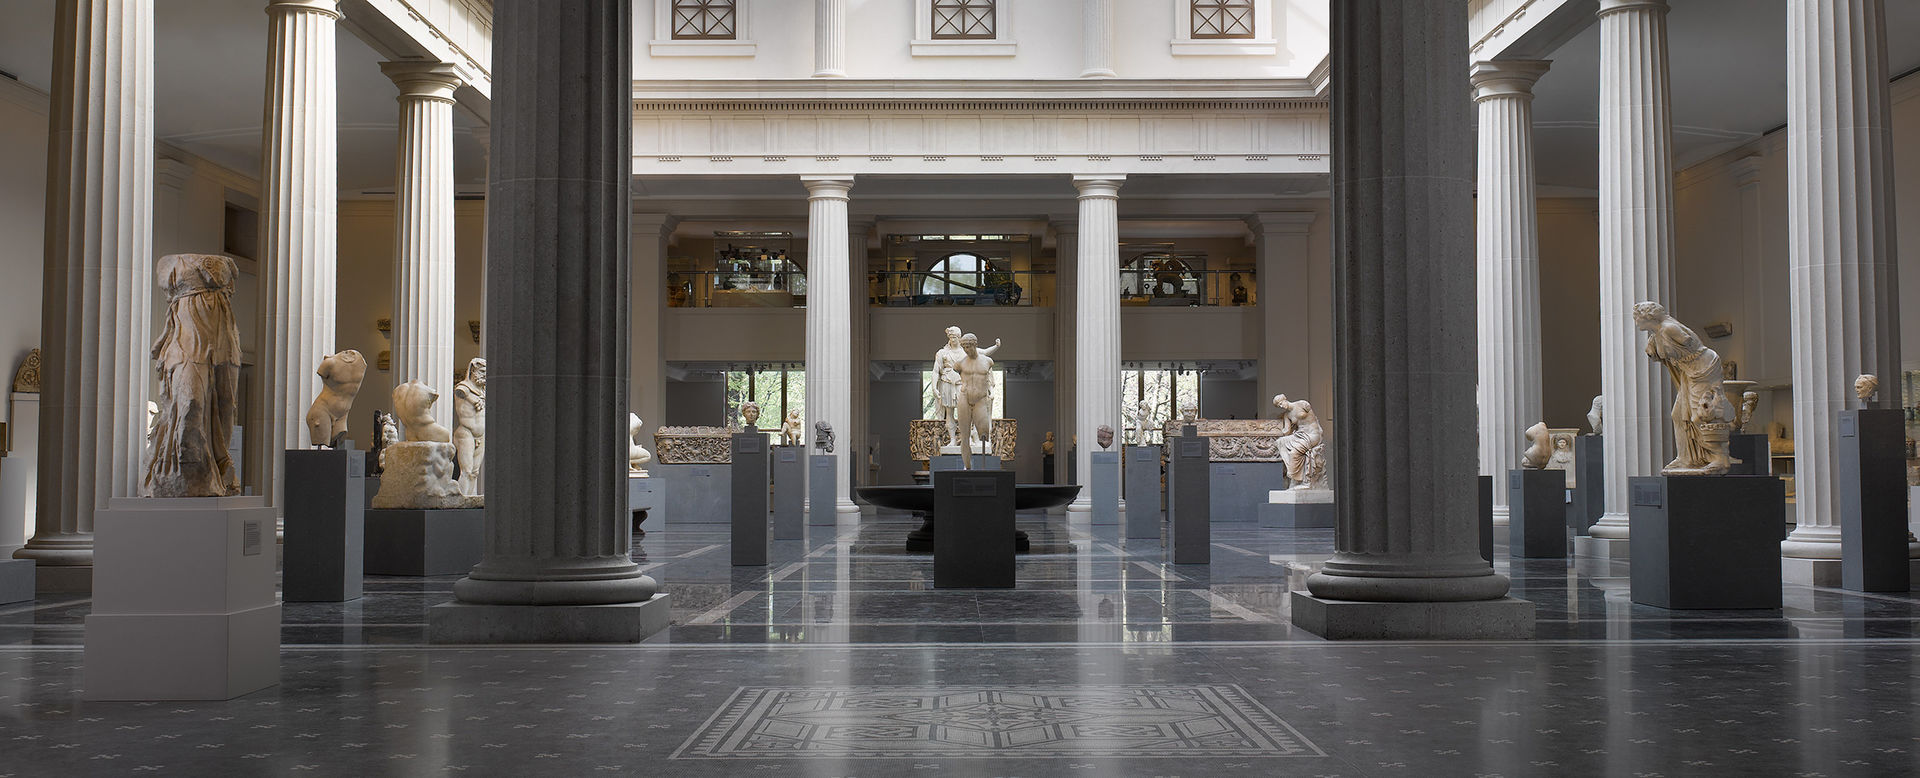

The <a href="https://www.metmuseum.org/about-the-met/collection-areas/greek-and-roman-art/bothmer-fragment-collection">collection</a> is a study resource of over 16,000 fragments of Greek vases assembled by Dietrich von Bothmer, former head of the Department of Greek and Roman Art at The Metropolitan Museum of Art. Bothmer began acquiring the pieces in the late 1960s, around the time he began to teach. On his death in 2009, he bequeathed them to The Met, which accepted them with the approval of the Italian Ministry for Cultural Property and Activity. Between 2013 and 2018, the Department of Greek and Roman Art, together with the Imaging and Digital Departments, accessioned, photographed, and digitized the collection. It is a work in progress that The Met is pleased to make available online. A selection of fragments is on view in gallery 157.

Born in 1918, Dietrich von Bothmer joined the Department of Greek and Roman Art at the Metropolitan Museum in 1946. He became head of the Department in 1959 and Chairman in 1973 until his retirement in 1990; thereafter, he was the Distinguished Research Curator until his death. While his competence extended to all areas of classical art, as reflected by his acquisitions, publications, and teaching, his particular expertise lay in Greek vase-painting, notably that of Athens.



In [44]:
# credit line
credit_line_2011 = df[df['AccessionYear']=='2011'].groupby('Credit Line')['Object Number'].count()
print(credit_line_2011.sort_values(ascending=False).head(1))

Credit Line
Gift of Dietrich von Bothmer, Distinguished Research Curator, Greek and Roman Art, 2011    16270
Name: Object Number, dtype: int64


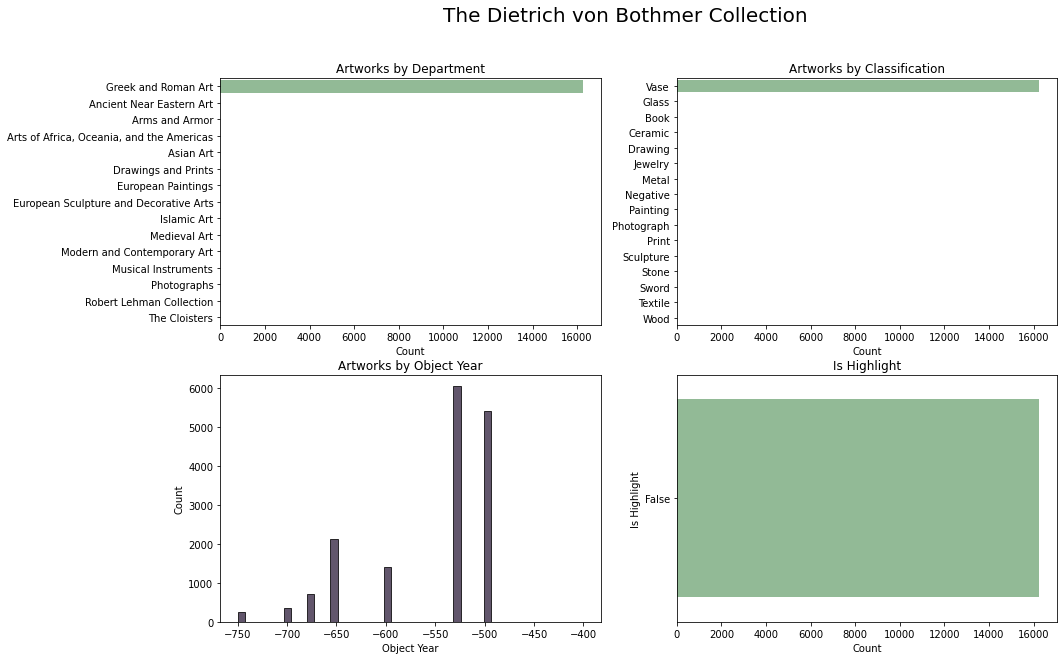

In [45]:
# bothmer collection visualization
bothmer = met_df.loc[(met_df['Accession Year']==2011) & 
                     (df['Credit Line']=='Gift of Dietrich von Bothmer, Distinguished Research Curator, Greek and Roman Art, 2011')]

fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.countplot(y='Department', data=bothmer, order=bothmer['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=bothmer, order=bothmer['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=bothmer[bothmer['Object Year']<=-400], ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.countplot(y='Is Highlight', data=bothmer, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Is Highlight', fontsize=12)
axes[1,1].set(xlabel='Count')
plt.suptitle('The Dietrich von Bothmer Collection', fontsize=20)
plt.show()

### The Walker Evans Archive

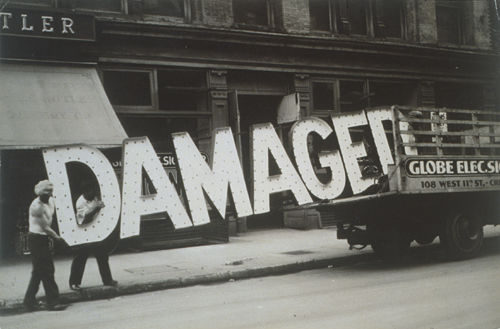

The Metropolitan Museum of Art will open the <a href="https://www.metmuseum.org/press/exhibitions/1999/the-metropolitan-museum-of-art-opens-walker-evans-archive-on-february-1">Walker Evans Archive</a>, one of the most complete single-artist archives of the 20th century, as a special research center devoted to the American photographer Walker Evans (1903-1975), on February 1, 2000. Acquired in 1994 by the Museum's Department of Photographs, the Walker Evans Archive includes Evans's black-and-white negatives, color transparencies, and motion-picture film from the late 1920s to the 1970s; the artist's original manuscripts, diaries, correspondence, and audiotape recordings of interviews and lectures; and his personal library and collections. This extraordinary trove will provide artists and scholars with a rare insight not only into the artistic achievement of Walker Evans, but also into the cultural, intellectual, and personal context of his career. \[ . . .\] The Walker Evans Archive has been designated a National Treasure by Save America's Treasures, a public-private partnership between the National Trust for Historic Preservation and the White House Millennium Council dedicated to raising awareness of and protecting America's irreplaceable historic and cultural legacy.

In [46]:
# credit line
credit_line_1994 = df[df['AccessionYear']=='1994'].groupby('Credit Line')['Object Number'].count()
print(credit_line_1994.sort_values(ascending=False).head(1))

Credit Line
Walker Evans Archive, 1994    7942
Name: Object Number, dtype: int64


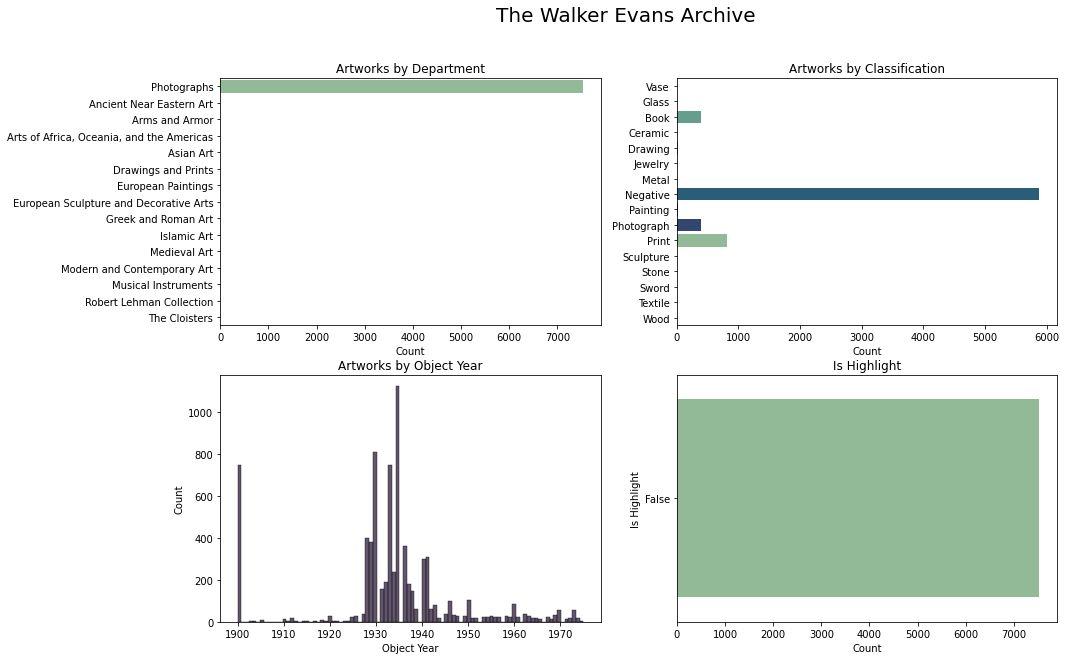

In [84]:
# evans archive visualization
evans = met_df.loc[(met_df['Accession Year']==1994) & 
                     (df['Credit Line']=='Walker Evans Archive, 1994')]

fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.countplot(y='Department', data=evans, order=evans['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=evans, order=bothmer['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=evans[evans['Object Year']>=1900], ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.countplot(y='Is Highlight', data=evans, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Is Highlight', fontsize=12)
axes[1,1].set(xlabel='Count')
plt.suptitle('The Walker Evans Archive', fontsize=20)
plt.show()

### J. Pierpont Morgan Gift, 1917

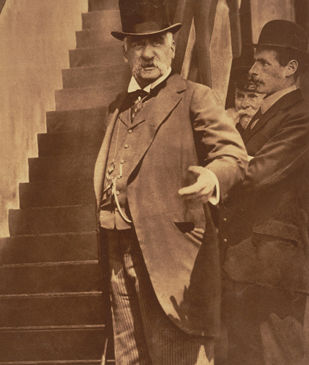

<a href="https://www.metmuseum.org/events/programs/met-speaks/ticketed-talks/tedxmet/participants/2013/j-pierpont-morgan">J. Pierpont Morgan</a> (1837–1913) was one of the greatest benefactors in the Metropolitan Museum's history. A dominating ﬁgure in the world of American ﬁnance for more than ﬁfty years, Morgan pursued a second career as a collector of art with equal vigor. His appetite for collecting was legendary, and his association with the Met spanned four decades. It began when he became a patron in 1871, then a trustee in 1888, continued with gifts of works of art (the ﬁrst in 1897), and reached its high point when he became president in 1904, an ofﬁce he held until his death in 1913. The ﬁnal chapter in this association was written in 1917, when his son, J.P. Morgan Jr., gave the Met much of his father's collection, including works that had been on loan to almost every department at the time of his death. The 1917 gift of some seven thousand objects was among the largest and most varied ever accepted by this institution.

In [48]:
# credit line
credit_line_1917 = df[df['AccessionYear']=='1917'].groupby('Credit Line')['Object Number'].count()
print(credit_line_1917.sort_values(ascending=False).head(1))

Credit Line
Gift of J. Pierpont Morgan, 1917    4571
Name: Object Number, dtype: int64


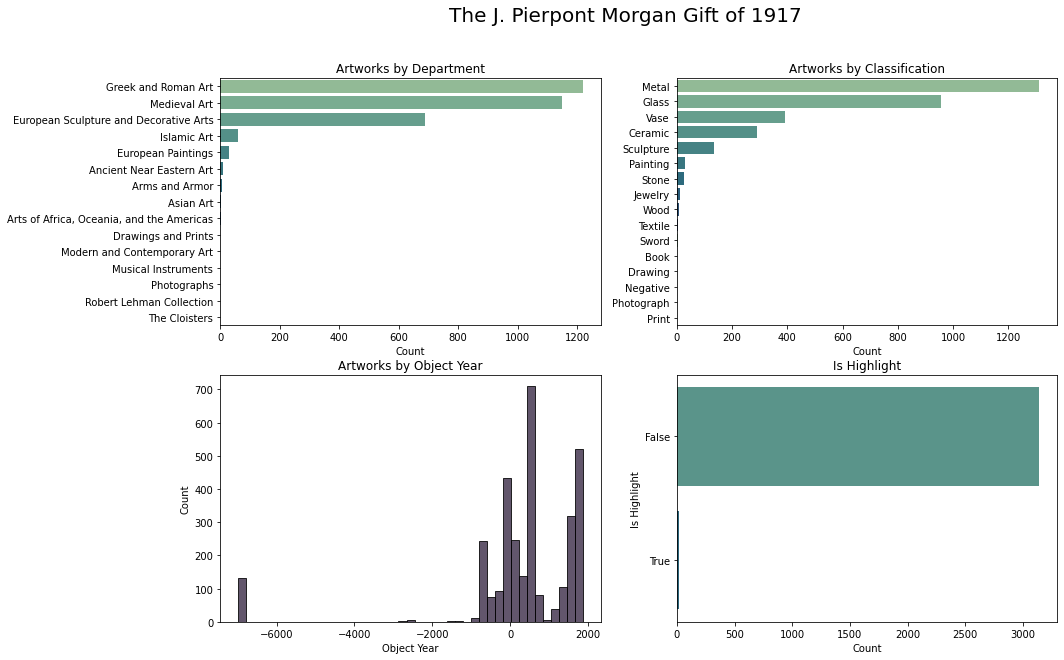

In [85]:
# morgan gift visualization
morgan = met_df.loc[(met_df['Accession Year']==1917) & 
                     (df['Credit Line']=='Gift of J. Pierpont Morgan, 1917')]

fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.countplot(y='Department', data=morgan, order=morgan['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=morgan, order=morgan['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=morgan, ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.countplot(y='Is Highlight', data=morgan, ax=axes[1,1], palette=sns.color_palette('crest',2))
axes[1,1].set_title('Is Highlight', fontsize=12)
axes[1,1].set(xlabel='Count')
plt.suptitle('The J. Pierpont Morgan Gift of 1917', fontsize=20)
plt.show()

### Special Collection Outliers

These special collections injected a large number of artworks of very specific and limited types in the overall Met Collection. Moreover, hardly any of these items ended up being highlight pieces. For our Random Forest data mining exercise, we will exclude these collections.

## Final Data Set & Highlight Artwork Data Mining

In [50]:
# create final, clean dataframe of displayed artwork that is not part of the special collections
met = met_df[met_df['Is Displayed'] == True].copy()
met = met.loc[ (df['Credit Line'] != 'The Jefferson R. Burdick Collection, Gift of Jefferson R. Burdick') &
               (df['Credit Line'] != 'Gift of Dietrich von Bothmer, Distinguished Research Curator, Greek and Roman Art, 2011') &
               (df['Credit Line'] != 'Walker Evans Archive, 1994') & (df['Credit Line'] != 'Gift of J. Pierpont Morgan, 1917') ]
met.shape

(281790, 7)

In [51]:
met.sample(5)

,Department,Is Highlight,Is Timeline Work,Is Displayed,Accession Year,Object Year,Classification
Object ID,,,,,,,
447474,Islamic Art,False,False,True,1922,1700,Textile
349184,Drawings and Prints,False,False,True,1963,1758,Book
738656,Drawings and Prints,False,False,True,1923,1893,Drawing
737704,Drawings and Prints,False,False,True,1959,1786,Print
212581,European Sculpture and Decorative Arts,False,False,True,1888,1500,Textile


In [64]:
met.describe()

,Accession Year,Object Year
count,281790.000000,281790.000000
mean,1954.352131,1560.018365
std,34.160803,731.651255
min,1870.000000,-11000.000000
25%,1928.000000,1600.000000
50%,1953.000000,1785.000000
75%,1979.000000,1878.000000
max,2021.000000,2021.000000


Let's create an overview visualizations of all displayed artwork in our final dataset, as well as the highlight pieces for comparison.

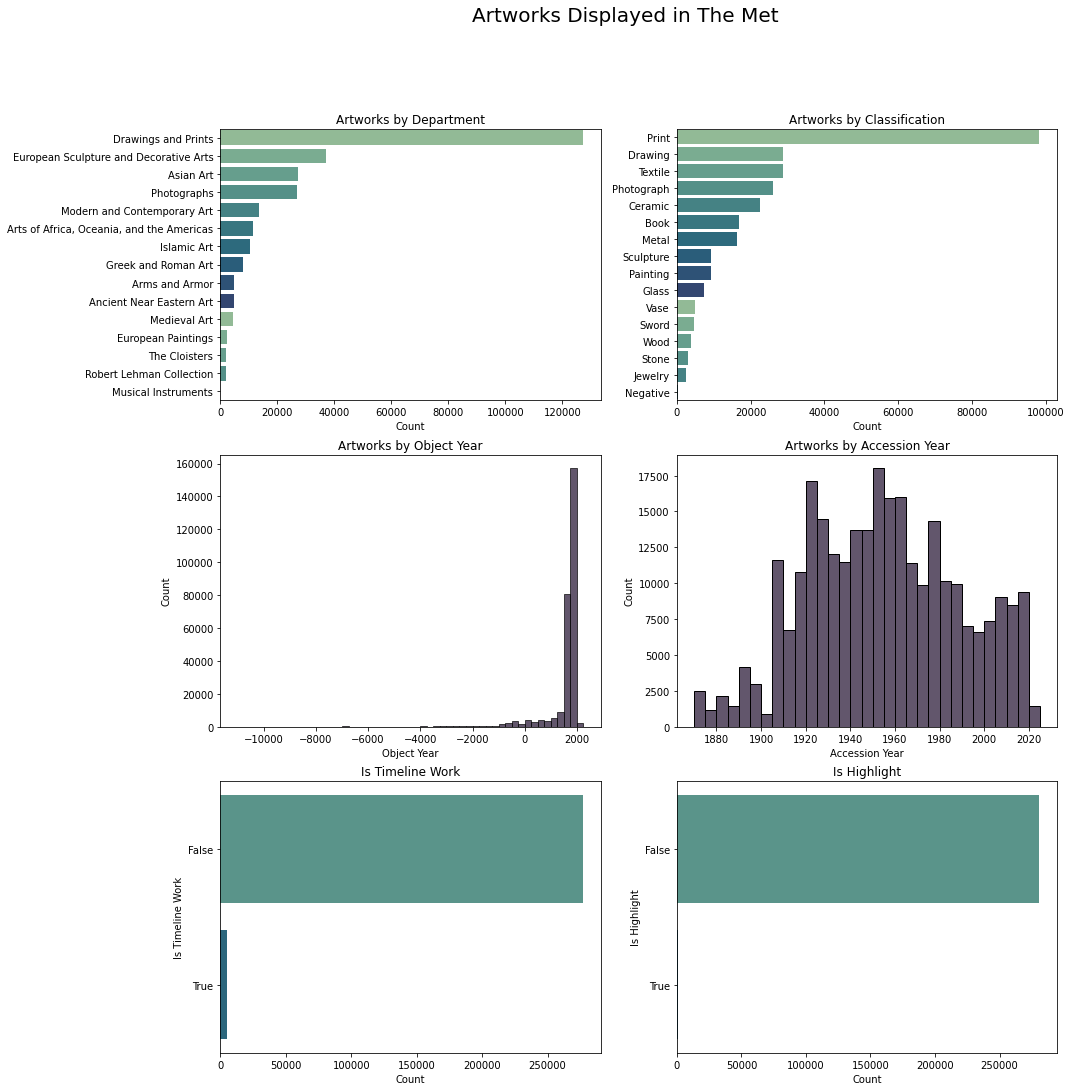

In [87]:
# overview visualization
fig, axes = plt.subplots(3, 2, figsize=(15,17))
sns.countplot(y='Department', data=met, order=met['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=met, order=met['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=met, binwidth=250, ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.histplot(x='Accession Year', data=met, binwidth=5, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Artworks by Accession Year', fontsize=12)
axes[1,1].set(ylabel='Count')
sns.countplot(y='Is Timeline Work', data=met, ax=axes[2,0], palette=sns.color_palette('crest',2))
axes[2,0].set_title('Is Timeline Work', fontsize=12)
axes[2,0].set(xlabel='Count')
sns.countplot(y='Is Highlight', data=met, ax=axes[2,1], palette=sns.color_palette('crest',2))
axes[2,1].set_title('Is Highlight', fontsize=12)
axes[2,1].set(xlabel='Count')
plt.suptitle('Artworks Displayed in The Met', fontsize=20)
plt.show()

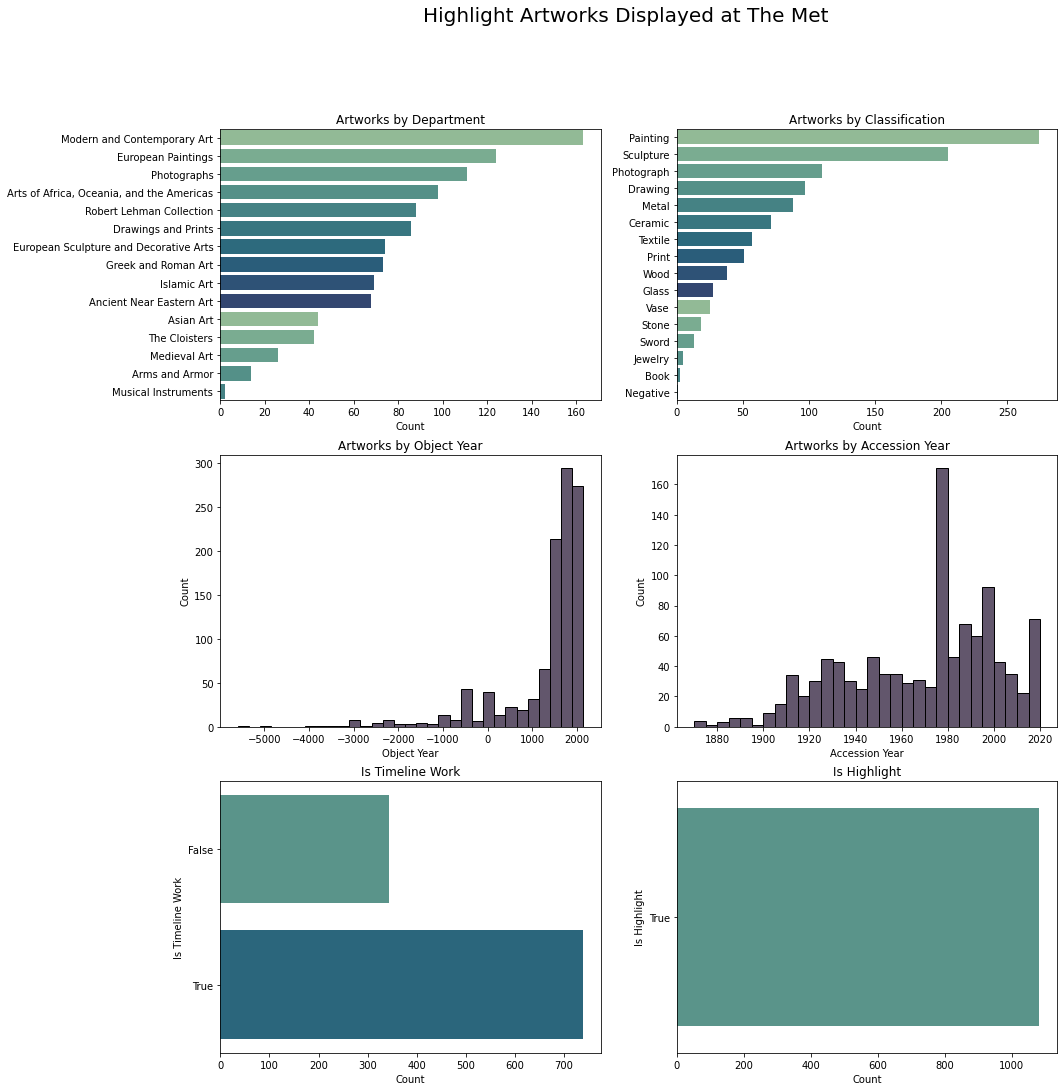

In [54]:
# highlight overview visualization
met_highlight = met[met['Is Highlight'] == True]

fig, axes = plt.subplots(3, 2, figsize=(15,17))
sns.countplot(y='Department', data=met_highlight, order=met_highlight['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=met_highlight, order=met_highlight['Classification'].value_counts().index, ax=axes[0,1],
              palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=met_highlight, binwidth=250, ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.histplot(x='Accession Year', data=met_highlight, binwidth=5, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Artworks by Accession Year', fontsize=12)
axes[1,1].set(ylabel='Count')
sns.countplot(y='Is Timeline Work', data=met_highlight, ax=axes[2,0], palette=sns.color_palette('crest',2))
axes[2,0].set_title('Is Timeline Work', fontsize=12)
axes[2,0].set(xlabel='Count')
sns.countplot(y='Is Highlight', data=met_highlight, ax=axes[2,1], palette=sns.color_palette('crest',2))
axes[2,1].set_title('Is Highlight', fontsize=12)
axes[2,1].set(xlabel='Count')
plt.suptitle('Highlight Artworks Displayed at The Met', fontsize=20)
plt.show()

Text here

### Random Forest Data Mining

text here

In [55]:
# one-hot encode categorical variables
onehot_df = met.copy()
onehot_df['Is Highlight'] = onehot_df['Is Highlight'].apply(lambda x: 1 if x == True else 0)
onehot_df['Is Timeline Work'] = onehot_df['Is Timeline Work'].apply(lambda x: 1 if x == True else 0)
onehot_df.drop(columns=['Is Displayed'], inplace=True)
onehot = pd.get_dummies(onehot_df, columns=['Department','Classification'])
onehot.sample(5)

,Is Highlight,Is Timeline Work,Accession Year,Object Year,Department_Ancient Near Eastern Art,Department_Arms and Armor,"Department_Arts of Africa, Oceania, and the Americas",Department_Asian Art,Department_Drawings and Prints,Department_European Paintings,...,Classification_Negative,Classification_Painting,Classification_Photograph,Classification_Print,Classification_Sculpture,Classification_Stone,Classification_Sword,Classification_Textile,Classification_Vase,Classification_Wood
Object ID,,,,,,,,,,,,,,,,,,,,,
482849,0,0,1983,1907,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
739079,0,0,1962,1819,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
481452,0,0,1975,1944,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
474787,0,0,1914,600,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
299406,0,0,2011,2002,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [56]:
# create arrays for random forest model
# research suggests scaling data for random forest is unnecessary
features = onehot.columns[1:]
X = onehot[onehot.columns[1:]].to_numpy()
y = onehot['Is Highlight'].to_numpy()

In [57]:
# # get random forest paramenters
# clf = RandomForestClassifier()
# param_grid = {
#                  'n_estimators': [15, 20, 50, 100],
#                  'max_features': [2, 5, 10, 15]
#              }
# grid_clf = GridSearchCV(clf, param_grid, cv=10)
# grid_clf.fit(X, y)

# print(grid_clf.best_estimator_)
# print(grid_clf.best_params_)

# # commenting this out for final report because it takes quite a while to run
# # RandomForestClassifier(max_features=2, n_estimators=20)
# # {'max_features': 2, 'n_estimators': 20}

RandomForestClassifier(max_features=2, n_estimators=20)
{'max_features': 2, 'n_estimators': 20}


In [58]:
# generate random forest model using best parameters
rf = RandomForestClassifier(n_estimators=20, max_features=2)
rf.fit(X, y)
y_rf = rf.predict(X)


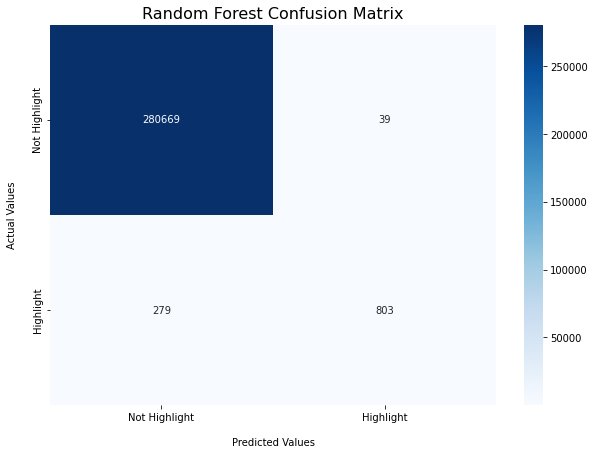

In [59]:
# confusion matrix to visualize random forest success
rf_cm = confusion_matrix(y, y_rf)

fig = plt.figure(figsize = (10,7))
ax = sns.heatmap(rf_cm, annot=True, cmap='Blues', fmt='g')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n')
ax.xaxis.set_ticklabels(['Not Highlight','Highlight'])
ax.yaxis.set_ticklabels(['Not Highlight','Highlight'])
plt.title('Random Forest Confusion Matrix', fontsize=16)
plt.show()

In [60]:
# random forest classification report
print('Random Forest Classification Report\n\n')
print(classification_report(y, y_rf, target_names=['Not Highlight','Highlight']))

Random Forest Classification Report


               precision    recall  f1-score   support

Not Highlight       1.00      1.00      1.00    280708
    Highlight       0.95      0.74      0.83      1082

     accuracy                           1.00    281790
    macro avg       0.98      0.87      0.92    281790
 weighted avg       1.00      1.00      1.00    281790



SHAP Values (an acronym from SHapley Additive exPlanations) break down tree predictions to show the impact of each feature.

In [61]:
# shap values to find important features
rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer.shap_values(X, approximate=True)

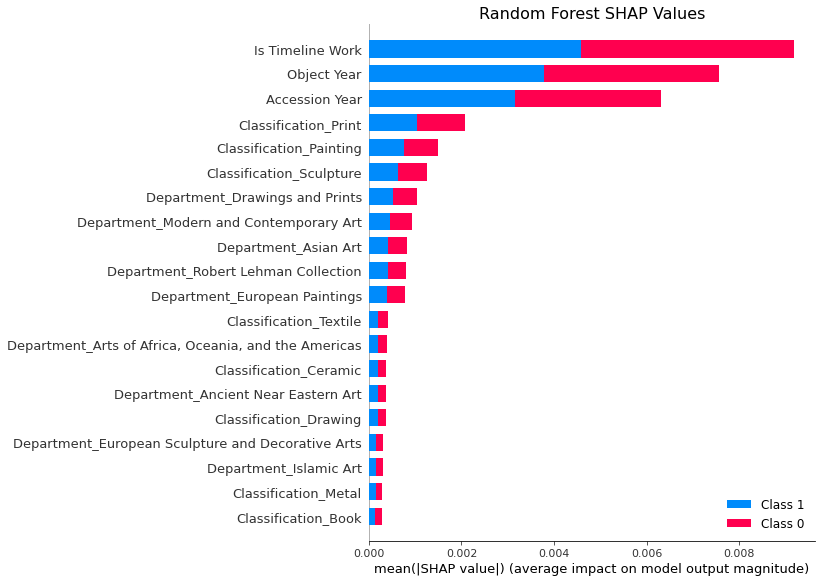

In [62]:
# plot shap values
fig = plt.figure(figsize=(15,7))
shap.summary_plot(rf_shap_values, features=X, feature_names=features, plot_type='bar', show=False)
plt.title('Random Forest SHAP Values', fontsize=16)
plt.show()

In [ ]:
# decision tree plot was attempted, but there were too many leaves for plot to be meaningful
# fig = plt.figure(figsize=(50, 50))
# plot_tree(rf.estimators_[0], 
#           feature_names=features,
#           class_names=['Not Highlight','Highlight'],
#           filled=True, 
#           impurity=True, 
#           rounded=True,
#           fontsize=10)
# plt.title('Random Forest Decision Tree', fontsize=16)
# plt.show()

## Conclusion

Text here